In [1]:
import os
os.chdir("../../")
print(os.getcwd())

d:\PhD_Projects\Mori-Zwanzig-Autoencoder


In [2]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd
from Data.KS.KS_order import KS
import pandas as pd
from statsmodels.tsa.stattools import ccf,acf
import csv

from matplotlib.animation import FuncAnimation

%matplotlib widget

In [4]:
torch.cuda.empty_cache()

exp_dir   = "G:/PhD_Imperial/PhD_Projects/MZA_Cluster_Models/ExpData/Exp8.1.3_NonParallel_NumObs_Test"


# pickle.load(open("Trained_Models/Cluster_Models/Exp4.2.4_Transient_2DCyl_MULTISTEP_numobstest_with_seqmodel_switch/sl33_nhu40_numobs3_bs16_lr5e-5_ph10/args"))
models = []


exp_name_list = [
                #  "sl5_nhu100_numobs3_bs64_numobs",\
                #  "sl5_nhu100_numobs6_bs64_numobs",\
                #  "sl5_nhu100_numobs8_bs64_numobs",\
                #  "sl5_nhu100_numobs12_bs64_numobs",\
                 "sl5_nhu100_numobs64_bs128__fs3_lr5e-4"
                ]

for exp_name in exp_name_list:#os.listdir(exp_dir):
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        i_model = Eval_MZA(exp_dir, exp_name)
        print(i_model.model.__dict__.keys())
        models.append(i_model)
models
# eval_mza = Eval_MZA(exp_dir, exp_name)

lt = 93.04

sl5_nhu100_numobs64_bs128__fs3_lr5e-4
########## Imp Info ##########
System:  ExpData
Using Non-Linear Autoencoder
dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_pre_hooks', '_state_dict_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'args', '_forward_pre_hooks_with_kwargs', '_forward_hooks_with_kwargs', '_state_dict_pre_hooks', '_backward_pre_hooks'])


In [51]:
print("Deactivate Model: ", models[0].deactivate_seqmodel)

Deactivate Model:  False


In [52]:
print("Pred horizon: ", models[0].pred_horizon)

Pred horizon:  10


Epoch with Minimum train_error:  1345
Epoch with Minimum test_error:  9


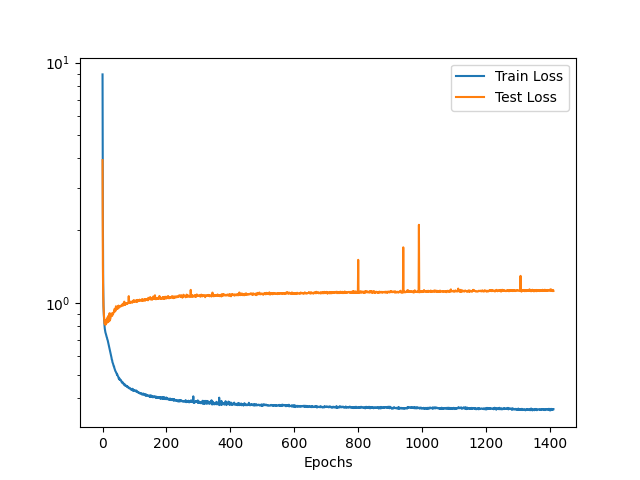

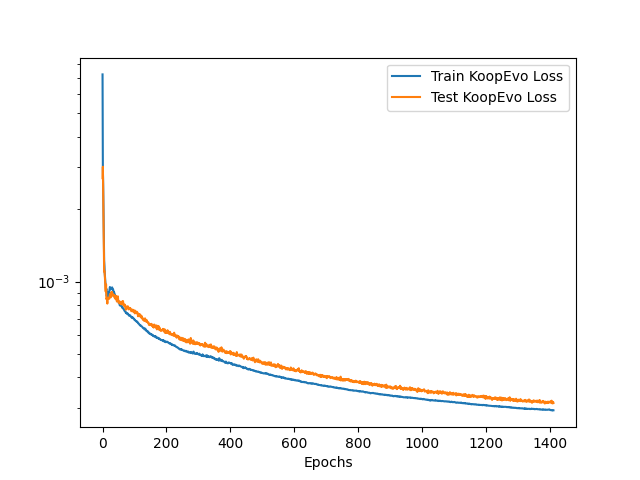

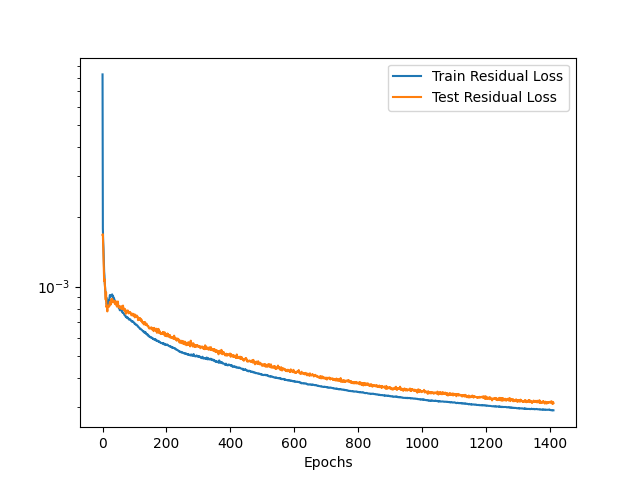

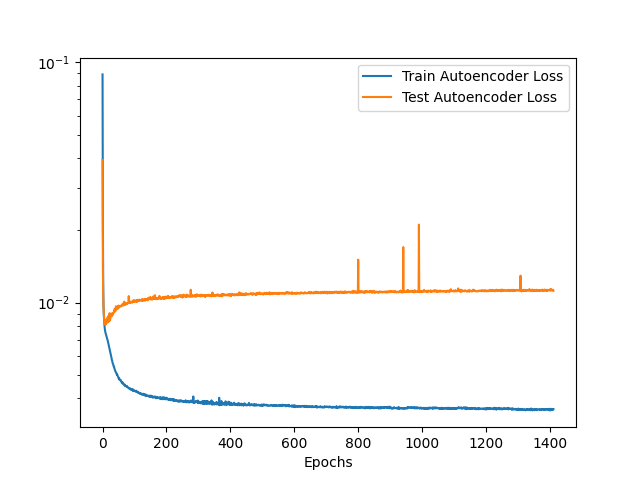

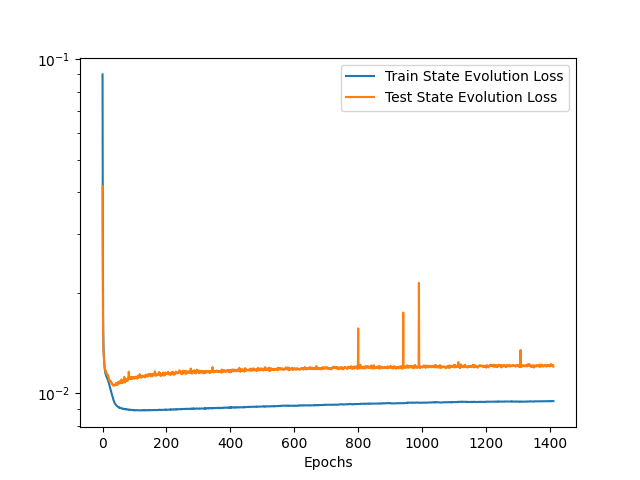

In [53]:
#plot learning curves
models[0].plot_learning_curves()

In [54]:
#for autoencoder_seq loading the strcuture separately for clarity and security
# for i in range(0,len(models)):
#     models[i].model.autoencoder = Autoencoder_seq(input_size = models[i].statedim, latent_size = models[i].num_obs, linear_ae = models[i].linear_autoencoder).to(models[0].device)

for i in range(0,len(models)):
    # if i == 2:
    #     epoch_num = 8000
    #     models[i].load_weights(epoch_num)
    epoch_num = 1000
    models[i].load_weights(epoch_num)#, True)

In [38]:
# for i in range(0,len(models)):

ph0 = models[0].pred_horizon 
models[0].pred_horizon = 1

In [56]:
#Load Dataset

model_num = 0
# models[model_num].data_dir = models[-2].data_dir
models[model_num].load_and_preproc_data()
models[model_num].train_size = 0.5
models[model_num].create_dataset(mode = "Train")
dataset = models[model_num].train_dataset
num_trajs = models[model_num].train_num_trajs

Data Shape:  (6, 5986, 2, 50, 79)
State Dims:  (2, 50, 79)
Not normalizing Input
Train_Shape:  (1, 5986, 2, 50, 79)
Time:  3.8165180683135986


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\utils\data\_utils\fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\utils\data\_utils\collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\utils\data\_utils\collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\utils\data\_utils\collate.py", line 160, in collate_tensor_fn
    storage = elem._typed_storage()._new_shared(numel, device=elem.device)
  File "d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\storage.py", line 732, in _new_shared
    untyped_storage = torch.UntypedStorage._new_shared(size * self._element_size(), device=device)
  File "d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\storage.py", line 222, in _new_shared
    return cls._new_using_filename_cpu(size)
RuntimeError: Couldn't open shared file mapping: <00000199B0E6FC12>, error code: <1455>


In [12]:

#One Step Prediction


# eval_mza.train_size = 0.9
for i in [0]:#len(models)):
    i=model_num
    
    # del eval_mza.lp_data 
    # torch.cuda.empty_cache()
    # del eval_mza.train_dataset
    # del eval_mza.train_dataloader
    if not models[i].deactivate_seqmodel:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE, koop_out, seqmodel_out = models[i].predict_onestep(dataset, num_trajs)
    else:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE = models[i].predict_onestep(dataset, num_trajs)
    print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

    #Plotting one step prediction
    x_nn_hat.shape

models[0].pred_horizon = ph0


0   torch.Size([32, 2, 50, 79])


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


1   torch.Size([32, 2, 50, 79])
2   torch.Size([32, 2, 50, 79])
3   torch.Size([32, 2, 50, 79])
4   torch.Size([32, 2, 50, 79])
5   torch.Size([32, 2, 50, 79])
6   torch.Size([32, 2, 50, 79])
7   torch.Size([32, 2, 50, 79])
8   torch.Size([32, 2, 50, 79])
9   torch.Size([32, 2, 50, 79])
10   torch.Size([32, 2, 50, 79])
11   torch.Size([32, 2, 50, 79])
12   torch.Size([32, 2, 50, 79])
13   torch.Size([32, 2, 50, 79])
14   torch.Size([32, 2, 50, 79])
15   torch.Size([32, 2, 50, 79])
16   torch.Size([32, 2, 50, 79])
17   torch.Size([32, 2, 50, 79])
18   torch.Size([32, 2, 50, 79])
19   torch.Size([32, 2, 50, 79])
20   torch.Size([32, 2, 50, 79])
21   torch.Size([32, 2, 50, 79])
22   torch.Size([32, 2, 50, 79])
23   torch.Size([32, 2, 50, 79])
24   torch.Size([32, 2, 50, 79])
25   torch.Size([32, 2, 50, 79])
26   torch.Size([32, 2, 50, 79])
27   torch.Size([32, 2, 50, 79])
28   torch.Size([32, 2, 50, 79])
29   torch.Size([32, 2, 50, 79])
30   torch.Size([32, 2, 50, 79])
31   torch.Size([32

In [13]:
Phi = models[0].train_data

(1, 5985)


Text(0, 0.5, 'MSE')

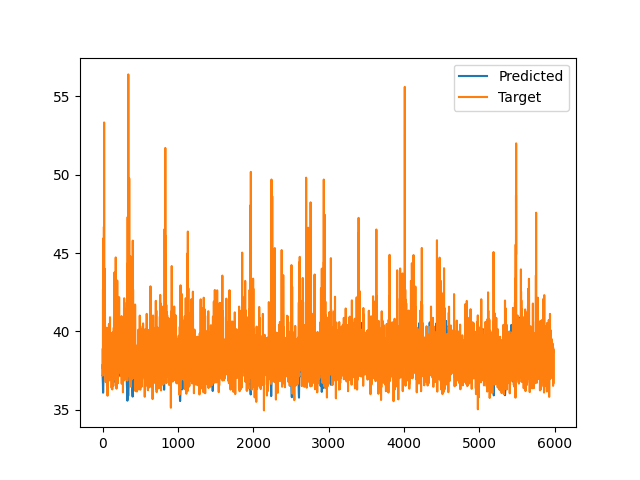

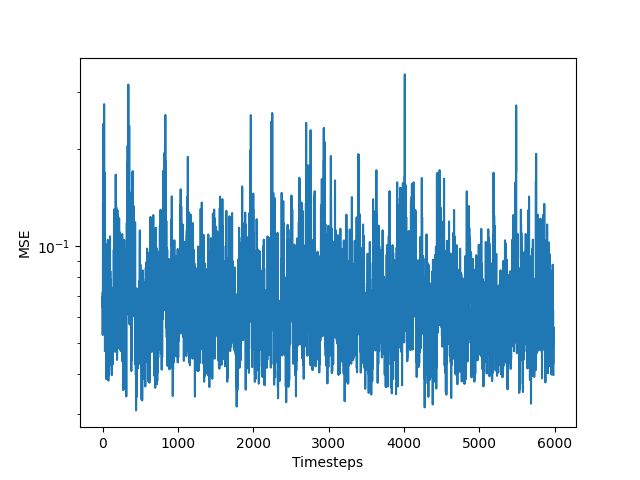

In [14]:
for i in [0]:
    Phi_nn_norm     = np.linalg.norm(np.linalg.norm(np.linalg.norm(Phi_nn.cpu().numpy(), axis = -1), axis = -1),axis = -1)
    Phi_nn_hat_norm = np.linalg.norm(np.linalg.norm(np.linalg.norm(Phi_nn_hat.cpu().numpy(), axis = -1), axis = -1),axis = -1)
    print(Phi_nn_hat_norm.shape)
    plt.figure()
    plt.plot(Phi_nn_norm[0,:], label = "Predicted")
    plt.plot(Phi_nn_hat_norm[0,:], label = "Target")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")

Multi Step

In [12]:
for i in range(len(models)):
    models[i].deactivate_seqmodel = False

In [15]:
models[0].statedim

(2, 50, 79)

In [55]:
#multistep prediction
timesteps = 3000
initial_step = 0
initial_conditions = (torch.from_numpy(models[0].lp_data[-1,initial_step,:][None,...]).to(torch.float)).to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat  = torch.zeros((len(models),1,timesteps+1,*models[0].statedim))
Phi_ms_koop = torch.zeros((len(models),1,timesteps,*models[0].statedim))

print("ic shape:", initial_conditions.shape)

for i in [0]:
    x_hat_temp, Phi_ms_hat[i], Phi_ms_koop[i], xkoop_hat_temp, xseq_hat_temp = (models[i].predict_multistep(initial_conditions, timesteps))
    x_ms_hat.append(x_hat_temp)
    xkoop_ms_hat.append(xkoop_hat_temp)
    xseq_ms_hat.append(xseq_hat_temp)
print(Phi_ms_hat.shape, Phi_ms_koop.shape)


AttributeError: 'Eval_MZA' object has no attribute 'lp_data'

Text(0, 0.5, 'kinetic energy')

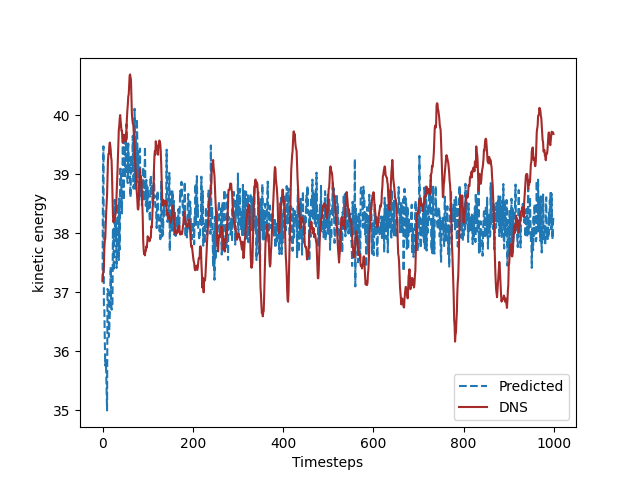

In [41]:
#kinetic energy of multistep rpediciton
def KS_kinetic_energy(Phi):
    k = np.linalg.norm(np.linalg.norm(np.linalg.norm(Phi, axis = -1), axis = -1),axis = -1)
    return k

plt.figure()

timesteps_ke = 3000
timesteps_dns = 3000
lt = 93.024
x = np.arange(timesteps_ke)/lt
x_dns = np.arange(timesteps_dns)/lt

for i in [0]:
    
    plt.plot(KS_kinetic_energy(Phi_ms_hat[i,0,0:timesteps_ke].detach().cpu().numpy()),"--", label = "Predicted")#f"Memory Length {round((models[i].seq_len - 1)/lt,2)}")

plt.plot(KS_kinetic_energy(models[0].lp_data[-1,initial_step:timesteps_dns+initial_step]), label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")


MovieWriter ffmpeg unavailable; using Pillow instead.


(50, 79) (50, 79)


MovieWriter ffmpeg unavailable; using Pillow instead.


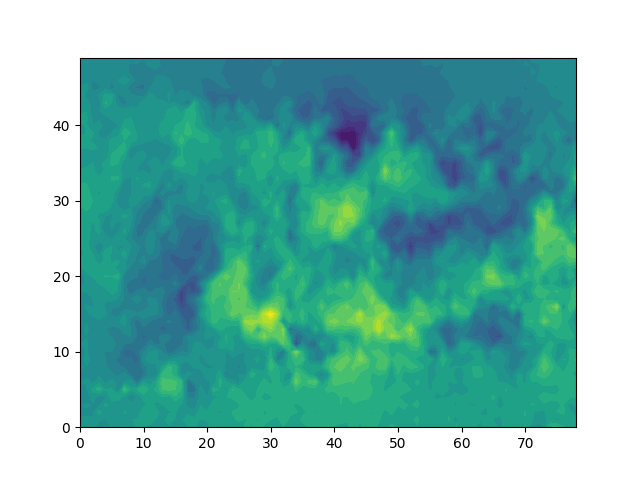

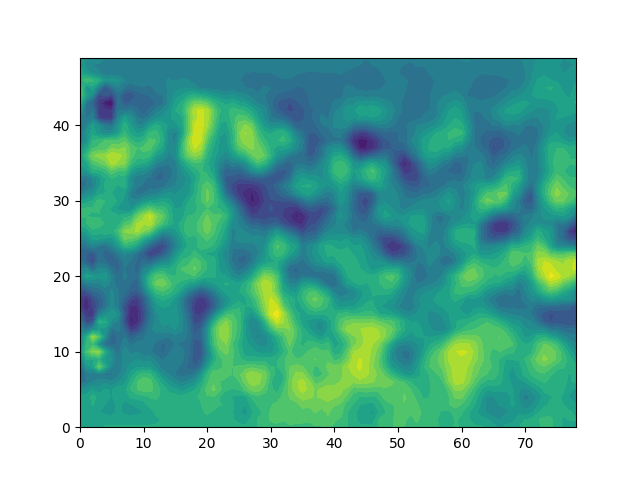

In [46]:
x = np.arange(models[0].lp_data.shape[-1])
y = np.arange(models[0].lp_data.shape[-2])

X,Y = np.meshgrid(x,y)
print(X.shape, Y.shape)

# plt.contourf(X,Y,data[1,1,0,...])
# plt.figure()
fig, ax = plt.subplots()

def update1(frame):
    ax.cla()  # Clear the previous frame
    Z = models[0].lp_data[-1,frame,1,...] # Update the data for the new frame
    contour = ax.contourf(X, Y, Z, levels=20)
    return contour

ani = FuncAnimation(fig, update1, frames=100, repeat=False)
# plt.show()
ani.save("DNS_full.gif")


fig2, ax2 = plt.subplots()

def update2(frame):
    ax2.cla()  # Clear the previous frame
    Z = Phi_ms_hat[0,0,frame,1,...] # Update the data for the new frame
    contour = ax2.contourf(X, Y, Z, levels=20)
    return contour

ani2 = FuncAnimation(fig2, update2, frames=100, repeat=False)
# ax2.colorbar()
ani2.save("prediciton.gif")

In [ ]:
#energy spectrum
dt = 0.025
N  = 256
num_trajs = 1
max_n = int(8000/dt)
L = 22/(2*np.pi)#1/np.sqrt(0.085)
kse = KS(dt=dt, N=N, lambda2=1, L = L)

plt.figure()

timesteps_ke = 1000
lt = 93.04
x = np.arange(1000)/lt

Phi_ms_hat_fft = np.fft.rfft(Phi_ms_hat.detach().cpu().numpy())
k_fft = 0.5*np.mean(np.abs(Phi_ms_hat_fft)**2, axis = -2)
print(k_fft[0,0].shape)
for i in [0,1,2,3,4]:
    
    plt.loglog(kse.k[:-1], k_fft[i,0,:-1], label = f"Memory Length {round((models[i].seq_len - 1)/lt,2)}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
Phi_fft = np.fft.rfft(Phi[0,initial_step:timesteps+initial_step], axis = -1)
print(Phi_fft.shape)
k_fft = 0.5*np.mean(np.abs(Phi_fft)**2, axis = 0)
plt.loglog(kse.k[:-1], k_fft[:-1], label = "DNS",color = "brown")

plt.legend(loc='upper right')
plt.xlabel(r"$\kappa$")
plt.ylabel("kinetic energy")

# plt.xlim(10, 1000)  # Set the x-axis limits in log scale
plt.ylim(1e-7, 1e6)  # Set the y-axis limits in log scale


Text(0, 0.5, '$\\mathcal{K}(x_{2})$')

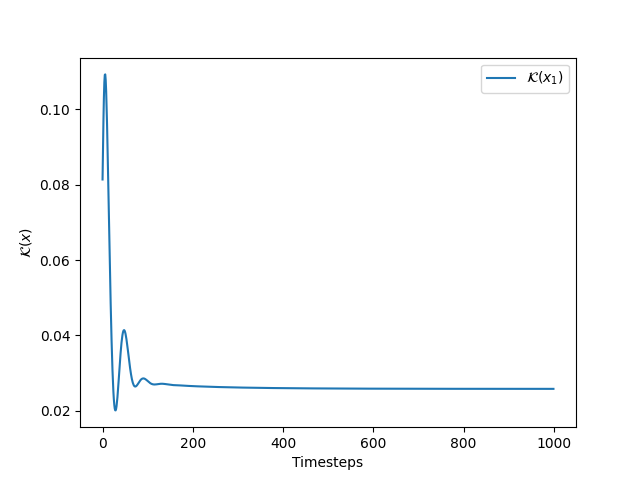

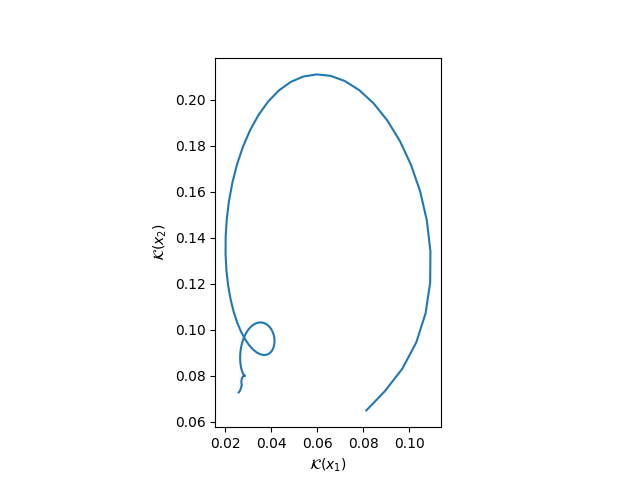

In [44]:
#plotting koopman mode evolution
plt.figure()
model_num = 0
for n in [0]:#range(models[model_num].num_obs):
    plt.plot(xkoop_ms_hat[model_num][0,:,n].cpu().numpy(), label = r"$\mathcal{K}$"+f"$(x_{n+1})$")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel(r"$\mathcal{K}(x)$")


plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xkoop_ms_hat[model_num][0,:,0].cpu().numpy(), xkoop_ms_hat[model_num][0,:,1].cpu().numpy())

plt.xlabel(r"$\mathcal{K}(x_{1})$")
plt.ylabel(r"$\mathcal{K}(x_{2})$")

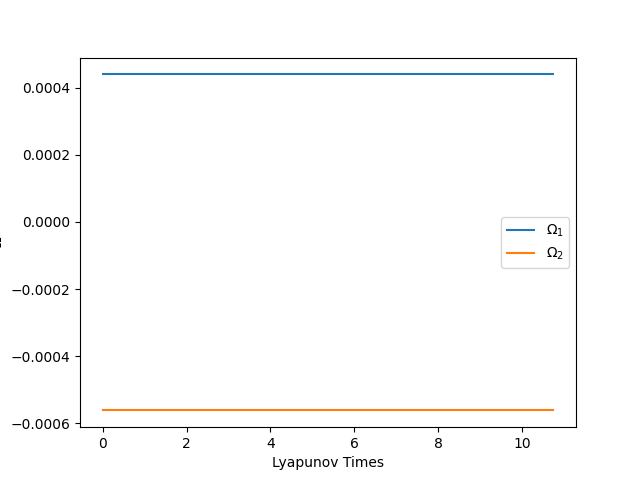

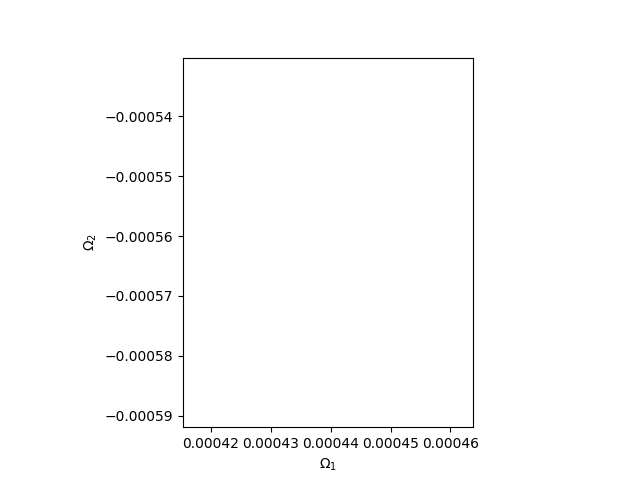

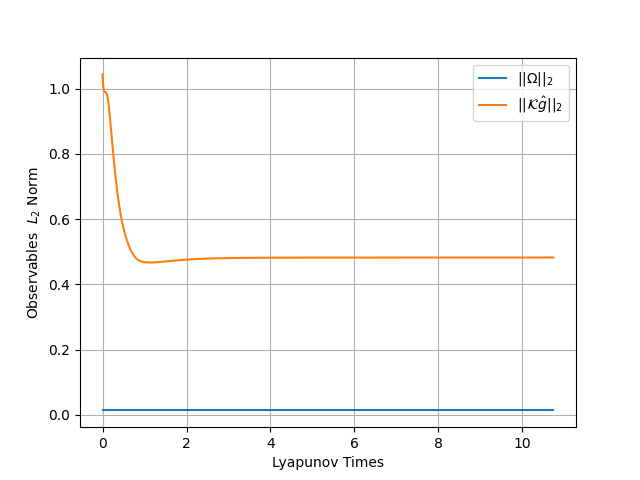

In [26]:
#plotting seqmodel mode evolution
plt.figure()
timesteps_ke = 1000
x = np.arange(timesteps_ke)/lt

model_num = 0
tgt_xseq_ms_hat = xseq_ms_hat[model_num].cpu().numpy()
tgt_xkoop_ms_hat = xkoop_ms_hat[model_num].cpu().numpy()
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(x, xseq_ms_hat[model_num][0,:timesteps_ke,n].cpu().numpy(), label = r"$\Omega$"+f"$_{n+1}$")

plt.legend()
plt.xlabel("Lyapunov Times")
plt.ylabel(r"$\Omega$")

plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xseq_ms_hat[model_num][0,:timesteps_ke,0].cpu().numpy(), xseq_ms_hat[model_num][0,:timesteps_ke,1].cpu().numpy())
plt.xlabel(f"$\Omega_{1}$")
plt.ylabel(f"$\Omega_{2}$")

plt.figure(dpi = 100)
tgt_xseq_norm = np.linalg.norm(tgt_xseq_ms_hat, axis = -1)
tgt_xkoop_norm = np.linalg.norm(tgt_xkoop_ms_hat, axis = -1)


# plt.plot((tgt_xseq_norm/np.max(tgt_xseq_norm, axis = -1))[0,:], label = r"$||\Omega||_{2}$")
# plt.plot((tgt_xkoop_norm/np.max(tgt_xkoop_norm, axis = -1))[0,:], label = r"$||\mathcal{K}(x)||_{2}$")

plt.plot(x, (tgt_xseq_norm)[0,:timesteps_ke], label = r"$||\Omega||_{2}$")
plt.plot(x, (tgt_xkoop_norm)[0,:timesteps_ke], label = r"$||\mathcal{K}\hat{g}||_{2}$")



plt.legend(loc = "upper right")
plt.xlabel("Lyapunov Times")
plt.grid("on")
plt.ylabel("Observables  " + r"$  L_{2}$" +  " Norm")

data_dict = {"x":x,"tgt_xseq_norm":(tgt_xseq_norm)[0,:],"tgt_xkoop_norm":(tgt_xkoop_norm)[0,:]} 

csv_file_name = 'Plotdata_csv/KS_contribution_norm.csv'

with open(csv_file_name, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    header = data_dict.keys()
    writer.writerow(header)

    for row in zip(*data_dict.values()):
        writer.writerow(row)

(1000, 1)
(1000, 1)


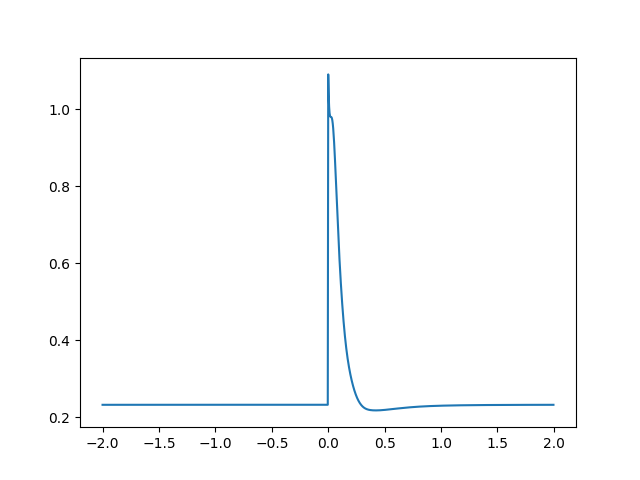

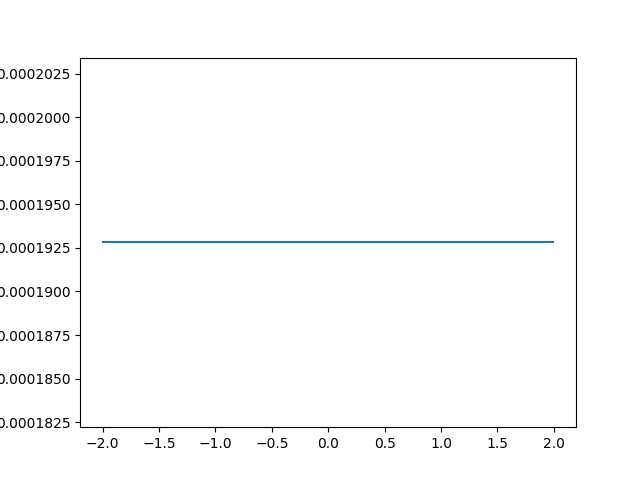

In [31]:
import scipy

data = tgt_xkoop_norm.T
ps = np.abs(np.fft.fft(data))**2

print(ps.shape)
time_step = 1 / 4
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

plt.figure()
plt.plot(freqs[idx], ps[idx])


data = tgt_xseq_norm.T
ps = np.abs(np.fft.fft(data))**2

print(ps.shape)
time_step = 1 / 4
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

plt.figure()
plt.plot(freqs[idx], ps[idx])
# plt.semilogy(f, S)
# plt.xlim([0, fs])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
# plt.show()

In [28]:
plt.plot(tgt_xseq_norm.squeeze(), tgt_xkoop_norm.squeeze(), ".")

d:\Anaconda\envs\tf-gpu\lib\site-packages\statsmodels\tsa\stattools.py:1104: RuntimeWarning: invalid value encountered in divide
  return cvf / (np.std(x) * np.std(y))


(1000,)

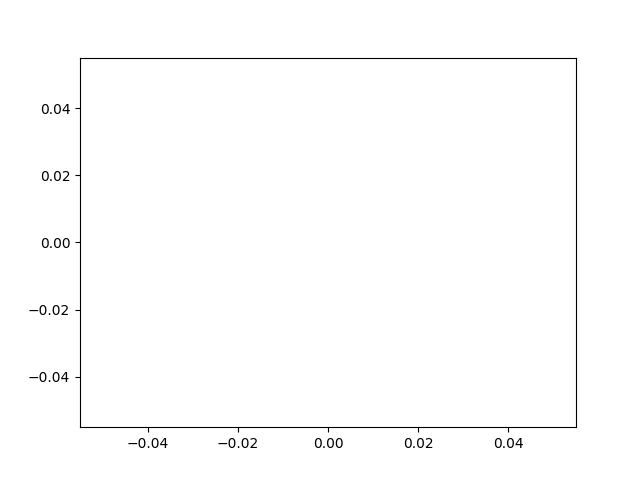

In [30]:
#CCF 1
tgt_xseq_norm_p = tgt_xseq_norm[0,:]
import pandas as pd
import statsmodels.tsa.stattools 
 

# plot the auto correlation
plt.figure()
plt.plot(statsmodels.tsa.stattools.ccf(tgt_xseq_norm.squeeze(), tgt_xkoop_norm.squeeze()))
statsmodels.tsa.stattools.ccf(tgt_xseq_norm.squeeze(), tgt_xkoop_norm.squeeze()).shape

In [48]:
#CCF2
from scipy import signal

def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c
    
ccf = ccf_values(tgt_xseq_norm.squeeze(), tgt_xkoop_norm.squeeze())
ccf

lags = signal.correlation_lags(len(tgt_xseq_norm.squeeze()), len(tgt_xseq_norm.squeeze()))

def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation Koopman norm and Memory Model norm', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    plt.xlim(-100,100)

ccf_plot(lags, ccf)

NameError: name 'tgt_xseq_norm' is not defined

torch.Size([1, 6499, 256]) torch.Size([7, 1, 6501, 256])


Text(0, 0.5, 'MSE')

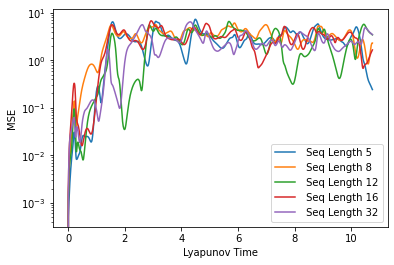

In [77]:
print(Phi_nn.shape, Phi_ms_hat.shape)
timesteps_mse = 1000
State_MSE_multistep = torch.zeros((len(models),timesteps_mse))

x = np.arange(timesteps_mse)/lt
plt.figure()
for i in [0,1,2,3,4]:#range(len(models)-3):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps_mse],Phi_ms_hat[i,:,:timesteps_mse]).detach().cpu()
    # if i!=len(models)-1:
    
    plt.semilogy(x, State_MSE_multistep[i].numpy(), label = f" Seq Length {models[i].seq_len - 1}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")

# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.legend()
plt.xlabel("Lyapunov Time")
plt.ylabel("MSE")
# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

Text(0, 0.5, 'MSE')

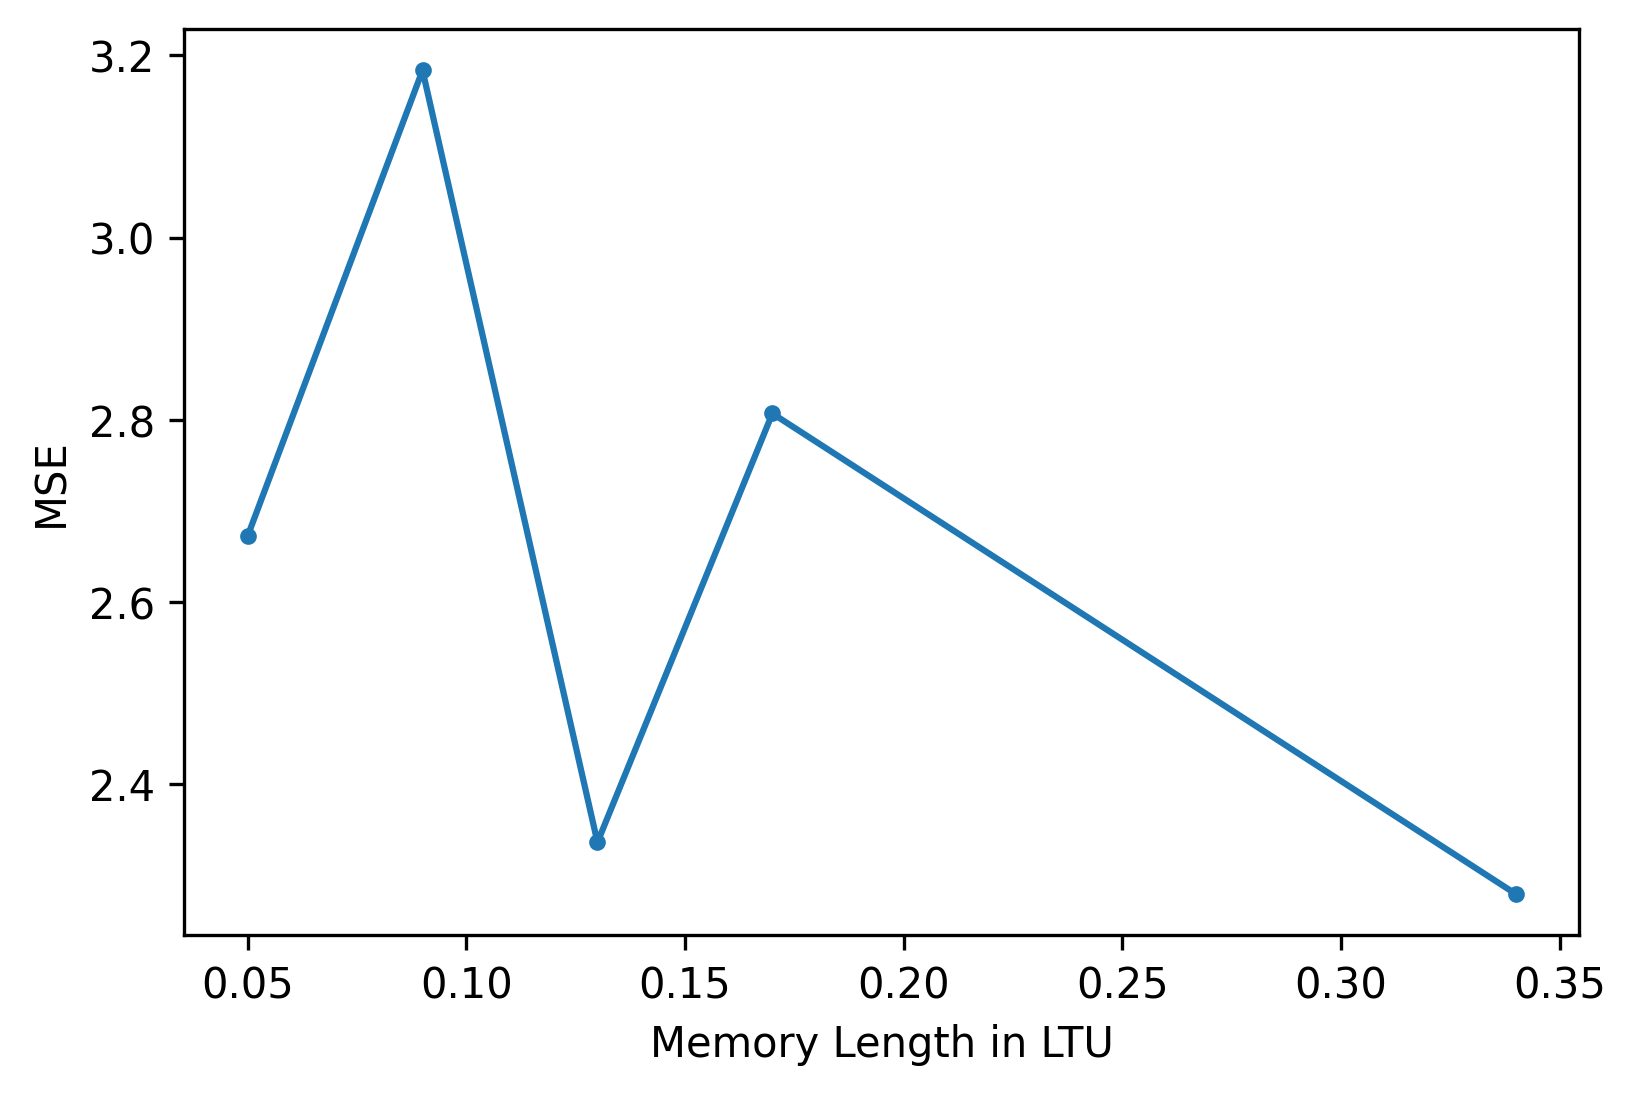

In [78]:
mse = []
mse_x = []
for i in [0,1,2,3,4]:#range(len(models)-3):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps_mse],Phi_ms_hat[i,:,:timesteps_mse]).detach().cpu()
    mse.append(np.mean(State_MSE_multistep[i].numpy()))
    mse_x.append(round((models[i].seq_len - 1)/lt,2))
    # if i!=len(models)-1:

plt.figure(dpi=300)
plt.plot(mse_x, mse, ".-")

plt.xlabel("Memory Length in LTU")
plt.ylabel("MSE")

In [ ]:
#calculating kinetic energy for multistep prediction
k_ms_pred = energy(U_ms_hat, V_ms_hat)
print(k_ms_pred.shape)
plt.figure()
for i in [0,1,2,3,4,5,6,7]:
    
    plt.plot(k_ms_pred[i,0,:], label = f"Number of Hidden Units {models[i].seq_len}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(k[0,initial_step:], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

Jacobian Analysis

In [19]:
#multistep prediction
timesteps_jac = 200
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps_jac+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps_jac,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

grad_xn_xseq = []

for i in [0,1,2,3,4]:#range(len(models)):
    
    grad_xn_xseq.append(models[i].jacobian_calc(initial_conditions, timesteps_jac))
    n = torch.mean(torch.norm(grad_xn_xseq[i].cpu(), dim = -1),dim = 1)
    print(i, n.shape)

print(grad_xn_xseq[0].shape)

ic shape: torch.Size([1, 256])
0 torch.Size([1, 5])
1 torch.Size([1, 8])
2 torch.Size([1, 12])
3 torch.Size([1, 16])
4 torch.Size([1, 32])
torch.Size([1, 200, 5, 8])


torch.Size([200])
0 torch.Size([1, 5])
1 torch.Size([1, 8])
2 torch.Size([1, 12])
3 torch.Size([1, 16])
4 torch.Size([1, 32])


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12428\2394778423.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([-tick for tick in plt.gca().get_xticks()])


Text(0.5, 0, 'Timesteps')

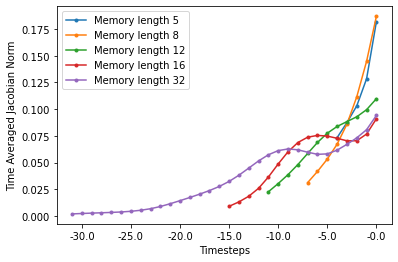

In [20]:
x = torch.arange(timesteps_jac)/lt
print(x[:].shape)
plt.figure()
for i in [0,1,2,3,4]:#range(len(models)):
    
    n = torch.mean(torch.norm(grad_xn_xseq[i].cpu(), dim = -1),dim = 1)
    print(i, n.shape)
    inv_n = torch.flip(n,[1])
    inv_x = torch.flip(x,[0])
    plt.plot( inv_n[0,:], ".-", label = f"Memory length {models[i].seq_len - 1}")
plt.legend()
plt.gca().invert_xaxis()
plt.gca().set_xticklabels([-tick for tick in plt.gca().get_xticks()])
plt.ylabel("Time Averaged Jacobian Norm")
plt.xlabel("Timesteps")

In [108]:


w, v = np.linalg.eig(grad_xn_xseq[0].cpu().numpy())

idx = w.argsort()[::-1]
w = w[idx]
v = v[:,idx]

print(w)

LinAlgError: Last 2 dimensions of the array must be square

Eigenvalue Study

[ 9.87658024e-01+0.0000000e+00j  9.69823360e-01+0.0000000e+00j
  9.67490971e-01+1.5852518e-02j  9.67490971e-01-1.5852518e-02j
  9.47433591e-01+5.4702483e-02j  9.47433591e-01-5.4702483e-02j
  9.42807436e-01+0.0000000e+00j  9.38100100e-01+1.8983472e-02j
  9.38100100e-01-1.8983472e-02j  9.37025249e-01+1.3417765e-01j
  9.37025249e-01-1.3417765e-01j  9.23574269e-01+2.1711210e-02j
  9.23574269e-01-2.1711210e-02j  9.20406401e-01+5.7501689e-02j
  9.20406401e-01-5.7501689e-02j  9.09013927e-01+0.0000000e+00j
  8.84200633e-01+0.0000000e+00j  8.83523285e-01+8.5764758e-02j
  8.83523285e-01-8.5764758e-02j  8.72509778e-01+4.7277033e-02j
  8.72509778e-01-4.7277033e-02j  8.68380904e-01+1.7415674e-02j
  8.68380904e-01-1.7415674e-02j  8.52818370e-01+0.0000000e+00j
  8.52046907e-01+1.9809876e-01j  8.52046907e-01-1.9809876e-01j
  8.45419466e-01+1.5032600e-01j  8.45419466e-01-1.5032600e-01j
  7.59895146e-01+0.0000000e+00j  7.05160916e-01+0.0000000e+00j
  6.04418933e-01+0.0000000e+00j  2.57022798e-01+0.00000

Text(0, 0.5, '$Img(\\lambda)$')

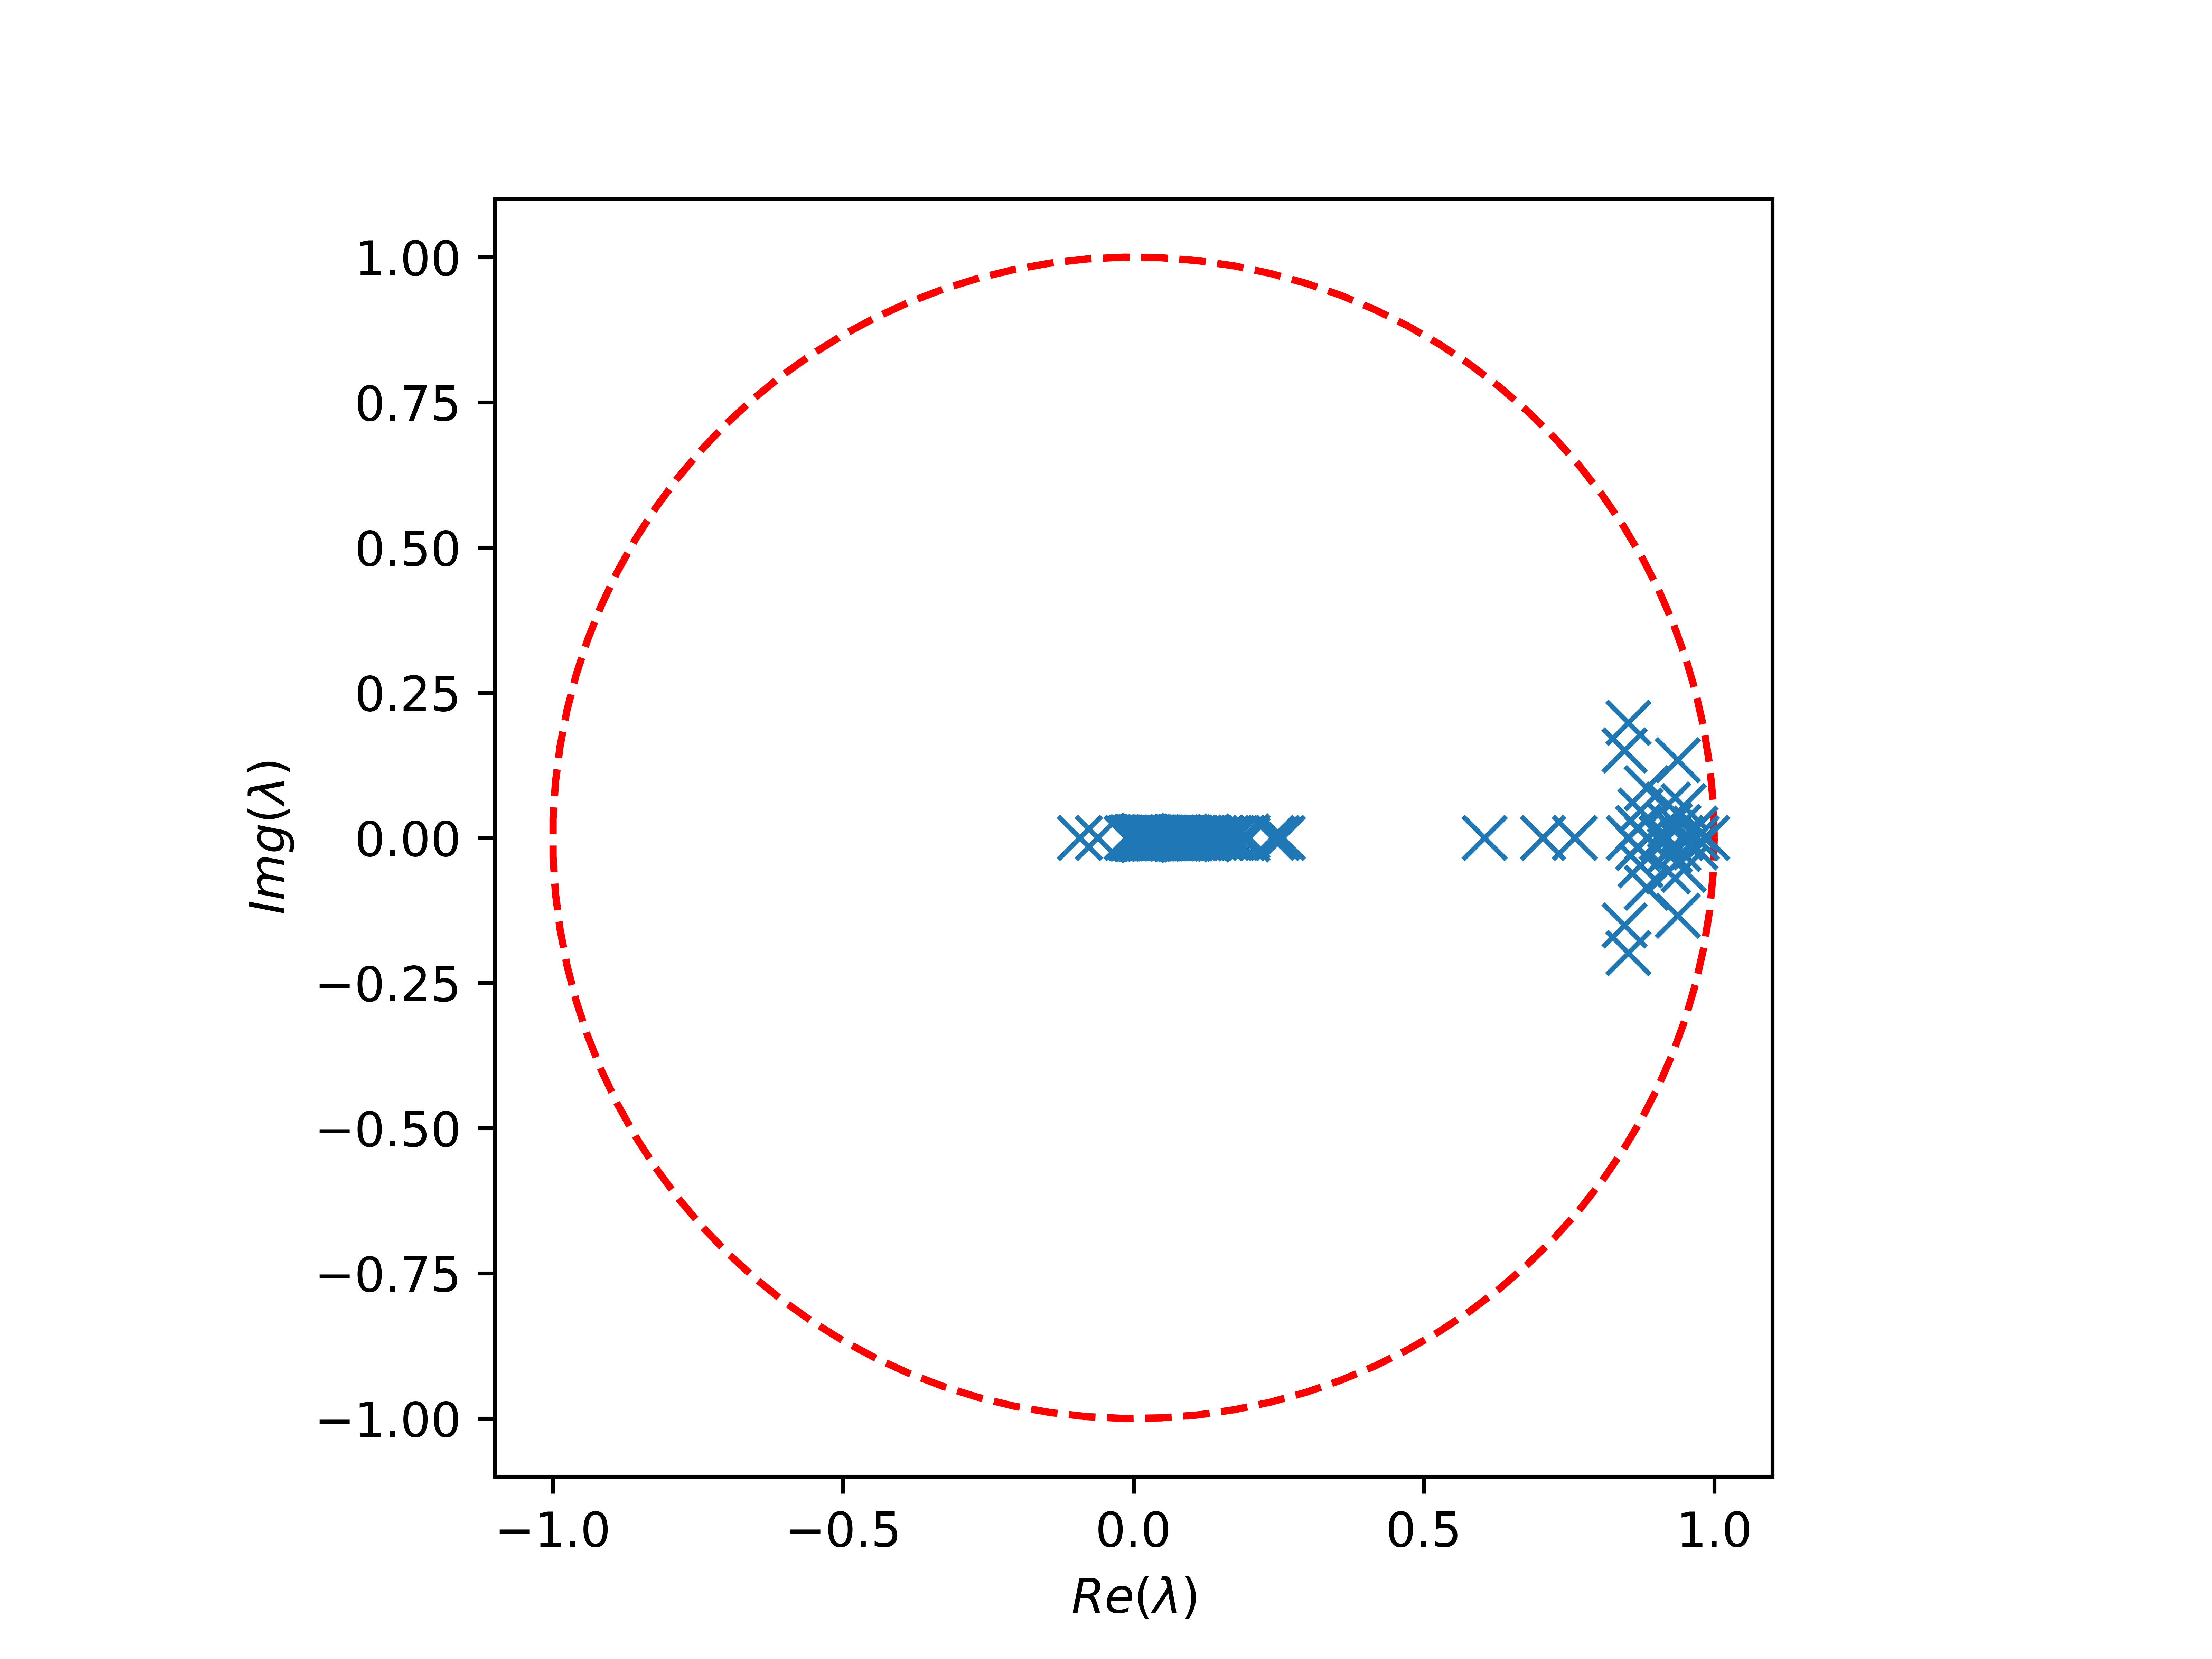

In [32]:
#eigenvalue study
plt.figure(dpi = 1000)
plt.gca().set_aspect('equal')

angles = np.linspace(0, 2 * np.pi, 100)
unit_circle = np.exp(1j * angles)
plt.plot(unit_circle.real, unit_circle.imag, '--', color = 'red', label = "Unit Circle")

for i in [-1]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    print(w)
    # plt.matshow(mat)
    # plt.colorbar()
    # plt.figure()
    plt.plot(np.real(w), np.imag(w), "x", markersize = 9, label = f"Num Observables {models[i].num_obs}")

plt.xlabel(r"$Re(\lambda)$")
plt.ylabel(r"$Img(\lambda)$")
# plt.legend()

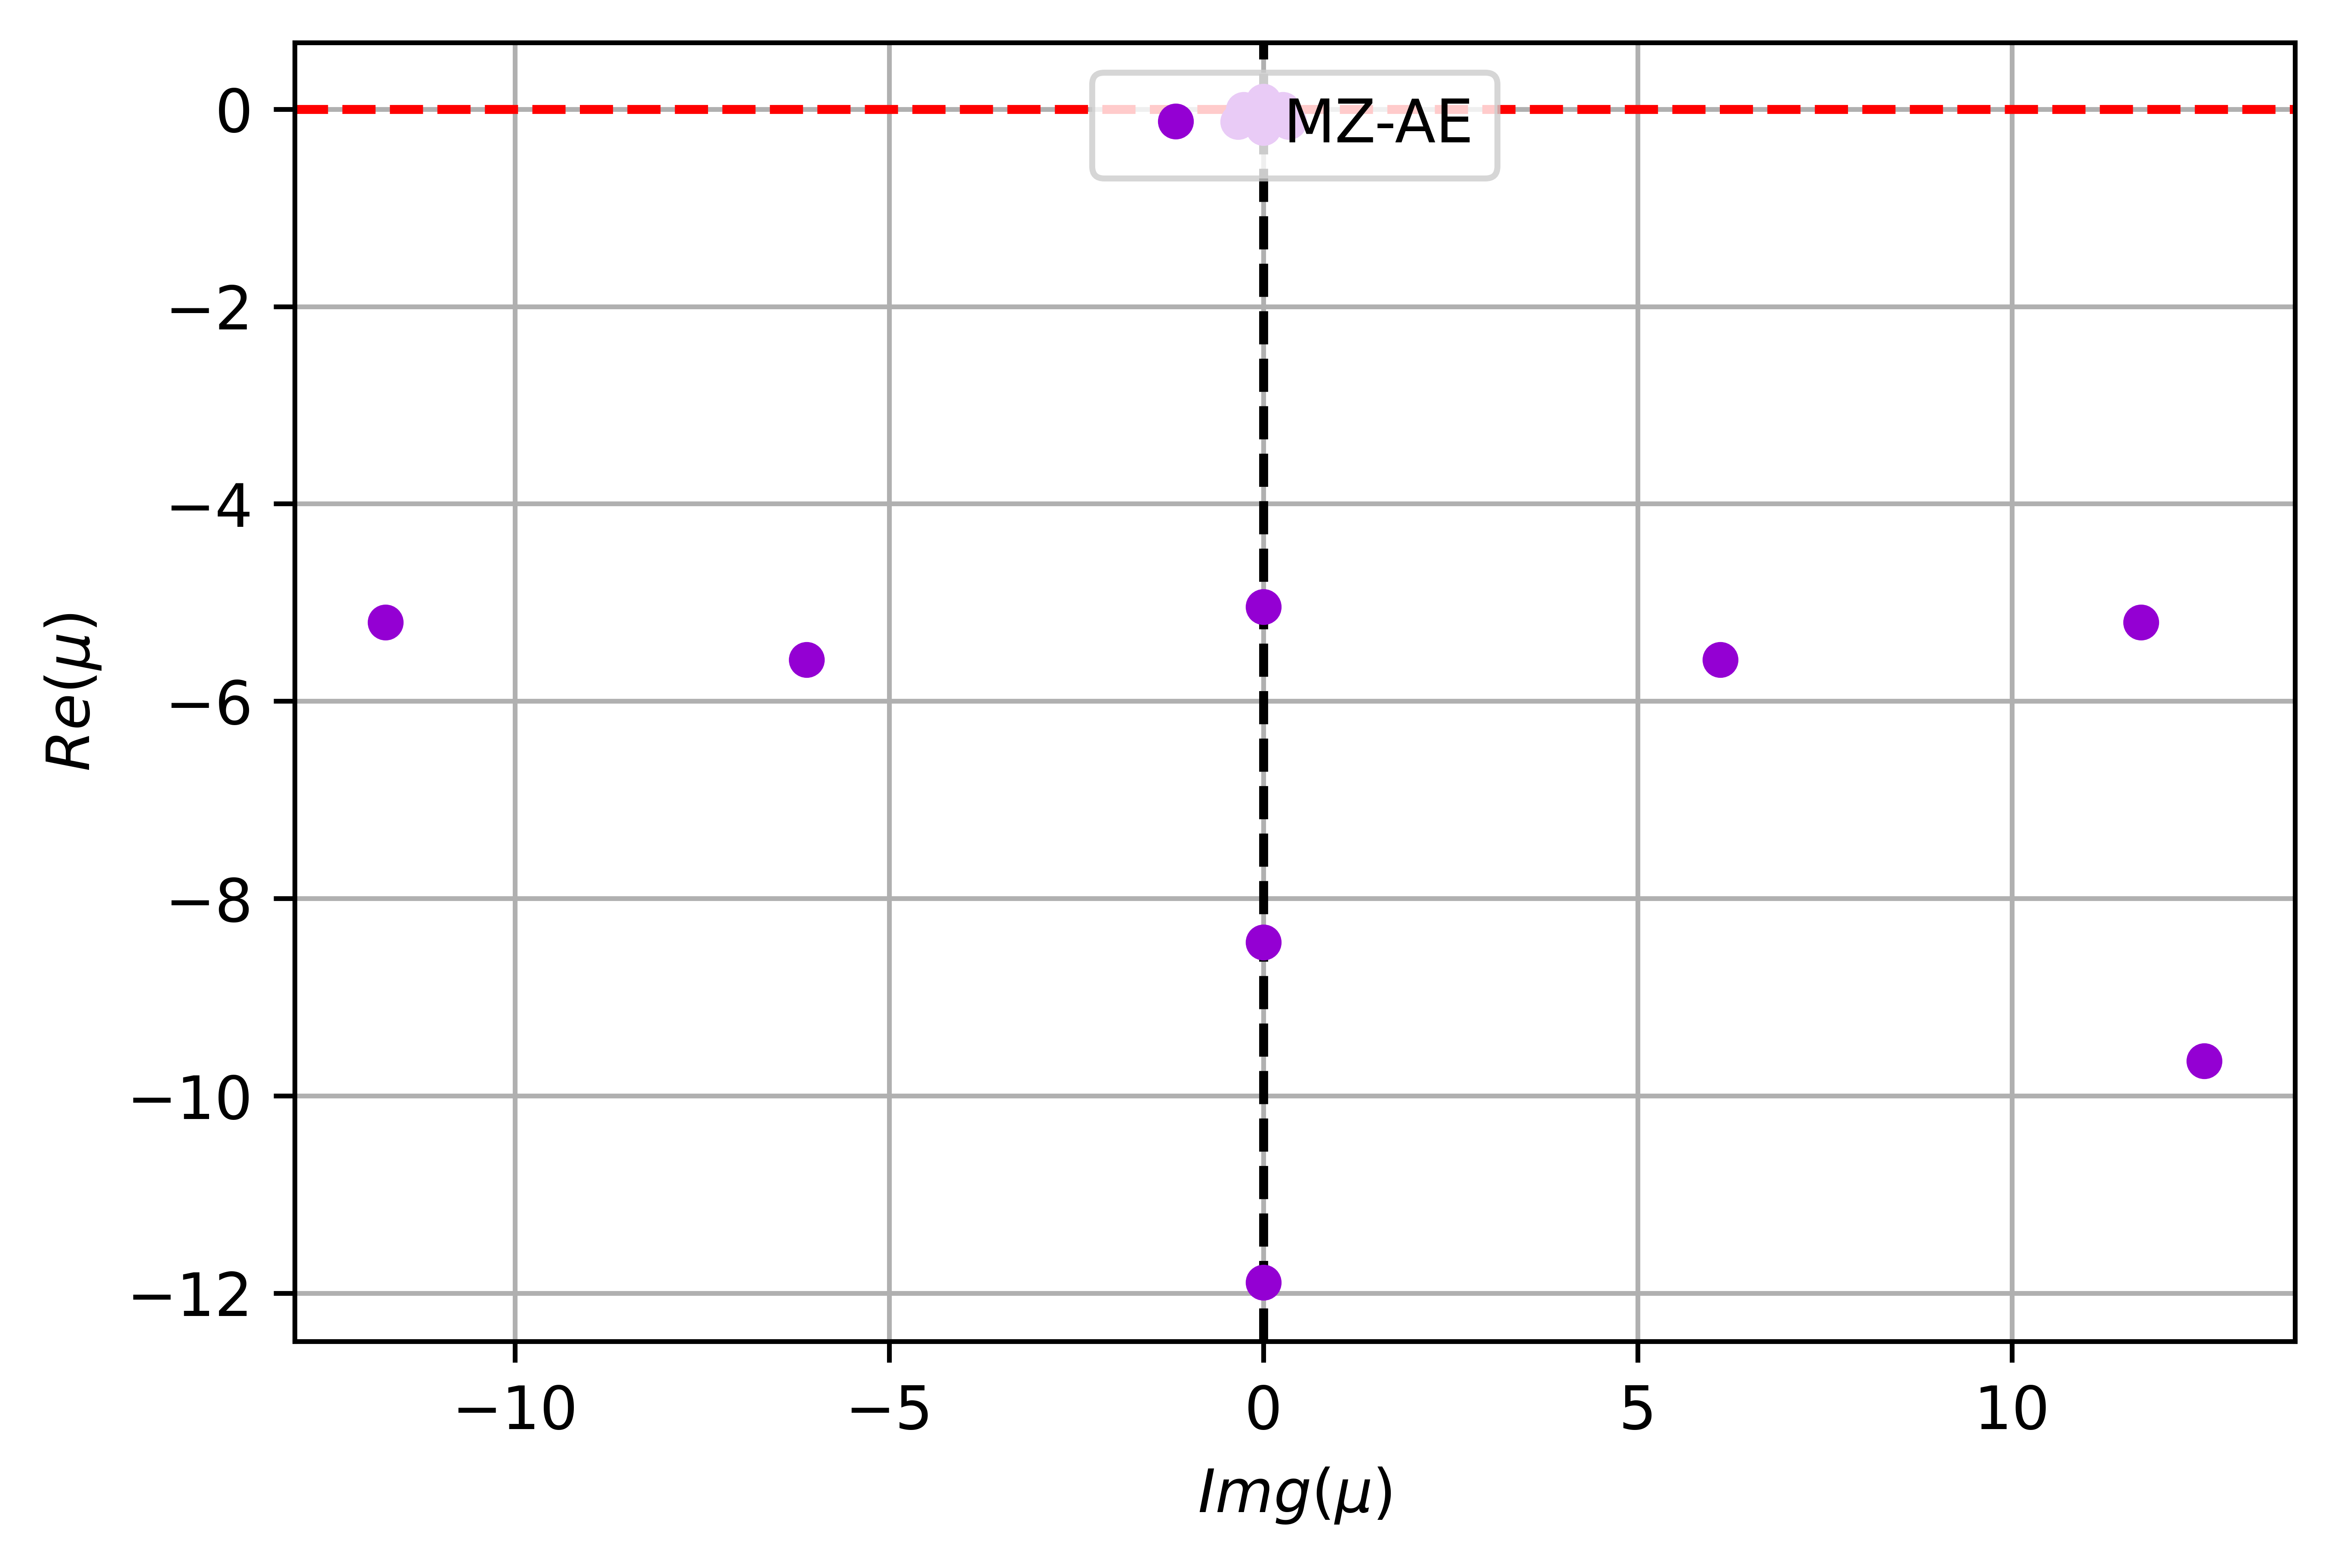

In [34]:
import copy
plt.figure(dpi = 1000)

plt.axhline(0, color='red', linestyle='--')
plt.axvline(x=0, color='black', linestyle='--')


# plt.text(0.17, 0.075, 'x = 0.17', color='green')
for i in [0]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    lamb = (np.log(w)/0.25)

    plt.plot(np.imag(lamb[:]),np.real(lamb[:]),".", color = "darkviolet", markersize = 10, label = "MZ-AE")
    lamb_mzae = copy.deepcopy(lamb)

plt.ylabel(r"$Re(\mu)$")
plt.xlabel(r"$Img(\mu)$")
plt.grid("on")
# plt.ylim(-0.15,0.1)
# plt.xlim(-1,1)
plt.legend(loc = "upper center")
# lamb


[[ 0.39355403  0.22014004  0.25933826  0.2013116  -0.30190548  0.06589104
  -0.4888595   0.03353363  0.2246169  -0.27123418  0.10407005  0.41139162
   0.00647267  0.04837595 -0.07893489  0.00178332]
 [ 0.31894457  0.28624716 -0.18159616 -0.0284834   0.31035966 -0.2994951
   0.18917544  0.07608137  0.33747303  0.10508151 -0.39137205 -0.24159035
   0.16682169 -0.20196395 -0.13982943 -0.10708164]
 [ 0.46218428 -0.16925012  0.4294138   0.10409472 -0.18194847  0.31355897
  -0.04556452  0.17626649  0.3897013   0.30474815  0.23241946 -0.08952804
  -0.39691737 -0.17029287 -0.50611234  0.20589148]
 [ 0.40367833  0.15699308 -0.29877403  0.6594807  -0.03099675 -0.05316471
   0.0461293  -0.11166923  0.01371571  0.21555369  0.14568976 -0.3401447
  -0.24019153  0.14882518  0.13228108 -0.22142039]
 [ 0.12810503  0.03956338 -0.10457996 -0.06042751  0.9339968  -0.10235516
   0.12462556 -0.0742842   0.06512703  0.07831495  0.05836881 -0.07176684
  -0.04044815  0.02548306 -0.05224069 -0.03421218]
 [-0.26

<Figure size 432x288 with 0 Axes>

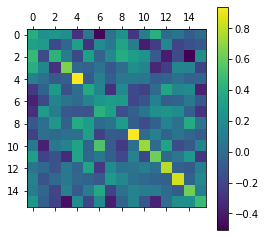

: 

In [49]:
#Matrix
plt.figure()


for i in [1]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    plt.matshow(mat)
    plt.colorbar()
    # plt.figure()
    # plt.plot(np.real(w), np.imag(w), ".", label = f"Num Observables {models[i].num_obs}")
    print(mat)
# plt.legend()

FREQUENCY RESPONSE ANALYSIS

In [157]:
import scipy
A = 0.1

T = 10 #Final timestep
dt = 0.25 #timesample size
t_set = np.arange(0,T,dt)
w_set = np.logspace(np.log10(1/T),np.log10(0.5*(1/dt)),120)
print(w_set)

ist_set = torch.zeros((1,1,models[0].num_obs))
ost_set = torch.zeros((1,1,models[0].num_obs))

input_signal  = torch.zeros((1,1,len(t_set),models[0].num_obs)) #[bs num_freq num_timesamples, num_obs]
output_signal = torch.zeros((1,1,len(t_set),models[0].num_obs)) #[bs num_freq num_timesamples, num_obs]

# input_signal_t  = torch.zeros((1,1,len(t_set),models[0].num_obs)) #[bs num_freq num_timesamples, num_obs]
# output_signal_t = torch.zeros((1,1,len(t_set),models[0].num_obs)) #[bs num_freq num_timesamples, num_obs]

for w in w_set:#range(models[0].num_obs):
    for t in t_set:
        ist = torch.eye(models[0].num_obs)[i]*t
        # print(ist)
        ist = ist[None,None,...] 
        ist = A*np.sin(w*ist)
        ost = models[0].model.seqmodel(ist.to(models[0].device))[None,...]
        # print(ost.shape)

        if t == 0:
            ist_set = ist
            ost_set = ost
        else:
            ist_set = torch.concat((ist_set,ist),axis = 1)  
            ost_set = torch.concat((ost_set,ost),axis = 1)  
        
        # ist = ist[None,None,...] #[bs(1) timeseq(1) numobs]
    if i == 0:
        input_signal_t  = ist_set[None,...]
        output_signal_t = ost_set[None,...]
    else:
        input_signal_t  = torch.concat((input_signal_t,  ist_set[None,...]), axis=1)
        output_signal_  = torch.concat((output_signal_t, ost_set[None,...]), axis=1)

    input_signal = torch.concat((input_signal, input_signal_t.to("cpu")), axis=0)
    output_signal = torch.concat((output_signal, output_signal_t.to("cpu")), axis=0)

input_signal = input_signal[1:,...]
output_signal = output_signal[1:,...]
print(output_signal.shape)
print(input_signal.shape)

cat = torch.concat((input_signal, output_signal), axis = 0).detach().numpy()
cat = {"input":input_signal.to("cpu").detach().numpy(),"output":output_signal.to("cpu").detach().numpy(), "time": t_set}


from scipy.io import savemat

# Specify the MAT file path
mat_file_path = 'test_freq.mat'

# Save the dictionary of NumPy arrays as a MAT file
savemat(mat_file_path, cat)

print(f'Data saved to {mat_file_path}')

[0.1        0.10254938 0.10516375 0.10784477 0.11059414 0.1134136
 0.11630494 0.11926999 0.12231063 0.12542879 0.12862644 0.13190561
 0.13526838 0.13871688 0.1422533  0.14587987 0.1495989  0.15341274
 0.15732381 0.16133459 0.16544761 0.1696655  0.17399091 0.17842659
 0.18297536 0.18764009 0.19242374 0.19732935 0.20236002 0.20751894
 0.21280937 0.21823469 0.22379831 0.22950377 0.23535469 0.24135477
 0.24750781 0.25381772 0.26028849 0.26692422 0.27372912 0.28070751
 0.2878638  0.29520253 0.30272836 0.31044605 0.31836049 0.32647669
 0.33479981 0.34333512 0.35208803 0.36106408 0.37026896 0.37970851
 0.38938871 0.3993157  0.40949576 0.41993535 0.43064108 0.44161975
 0.4528783  0.46442387 0.47626379 0.48840554 0.50085684 0.51362557
 0.52671982 0.54014789 0.5539183  0.56803976 0.58252124 0.5973719
 0.61260116 0.62821867 0.64423433 0.66065829 0.67750096 0.69477301
 0.71248539 0.73064933 0.74927633 0.76837821 0.78796706 0.80805531
 0.82865569 0.84978124 0.87144537 0.89366179 0.9164446  0.939808

d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([120, 1, 40, 16])
torch.Size([120, 1, 40, 16])
Data saved to test_freq.mat
